In [1]:
cd ../..

/userdata/jgauthier/projects/ideal-word-representations


In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
from pathlib import Path
import pickle

In [163]:
feature_selection_paths = list(Path("outputs/synthetic_encoders").glob("**/forward_selection.pkl"))
feature_selection_paths

[PosixPath('outputs/synthetic_encoders/timit/w2v2_7/basic50/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_7/basic10/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_0/basic10/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_0/basic50/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_10/basic50/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_10/basic10/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_4/basic10/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_4/basic50/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_3/basic10/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_3/basic50/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_9/basic50/forward_selection.pkl'),
 PosixPath('outputs/synthetic_encoders/timit/w2v2_9/basic10/for

In [164]:
feature_selection_results = {}
for path in feature_selection_paths:
    with open(path, "rb") as f:
        key = (path.parent.name, path.parents[1].name)
        result = pickle.load(f)
        feature_selection_results[key] = {"spec_trajectory": result["spec_trajectory"], "score_trajectory": result["score_trajectory"]}

In [165]:
score_df = pd.DataFrame([feature_selection_results[key]["score_trajectory"] for key in feature_selection_results],
                        index=pd.MultiIndex.from_tuples(feature_selection_results.keys(), names=["encoder", "base_model"])) \
                            .reset_index().melt(id_vars=["encoder", "base_model"], var_name="step", value_name="score")
score_df

,encoder,base_model,step,score
0,basic50,w2v2_7,0,-inf
1,basic10,w2v2_7,0,-inf
2,basic10,w2v2_0,0,-inf
3,basic50,w2v2_0,0,-inf
4,basic50,w2v2_10,0,-inf
...,...,...,...,...
91,basic10,w2v2_2,3,0.197346
92,basic10,w2v2_11,3,0.140938
93,basic50,w2v2_11,3,0.062181
94,basic10,w2v2_5,3,0.198217


In [166]:
selection_df = pd.DataFrame([[traj[-1] if len(traj) > 0 else None
                            for traj in feature_selection_results[key]["spec_trajectory"]]
                            for key in feature_selection_results],
                            index=pd.MultiIndex.from_tuples(feature_selection_results.keys(), names=["encoder", "base_model"])).reset_index() \
    .melt(id_vars=["encoder", "base_model"], var_name="step", value_name="selected_embedding") \
    .dropna()
selection_df

,encoder,base_model,step,selected_embedding
24,basic50,w2v2_7,1,biphone_pred
25,basic10,w2v2_7,1,biphone_recon
26,basic10,w2v2_0,1,biphone_pred
27,basic50,w2v2_0,1,biphone_pred
28,basic50,w2v2_10,1,biphone_pred
...,...,...,...,...
91,basic10,w2v2_2,3,word_broad
92,basic10,w2v2_11,3,word_broad
93,basic50,w2v2_11,3,word_broad
94,basic10,w2v2_5,3,word_broad


In [167]:
merged_df = score_df.merge(selection_df, on=["encoder", "base_model", "step"]).set_index(["encoder", "base_model", "step"]).sort_index()
merged_df["improvement"] = merged_df.score.diff()
merged_df.loc[merged_df.index.get_level_values("step") == 1, "improvement"] = merged_df.loc[merged_df.index.get_level_values("step") == 1, "score"]
merged_df = merged_df.reset_index()
merged_df["base_model_class"] = merged_df.base_model.str.rsplit("_", n=1).str[0]
merged_df["base_model_layer"] = merged_df.base_model.str.rsplit("_", n=1).str[-1].astype(int)

<Axes: xlabel='step', ylabel='score'>

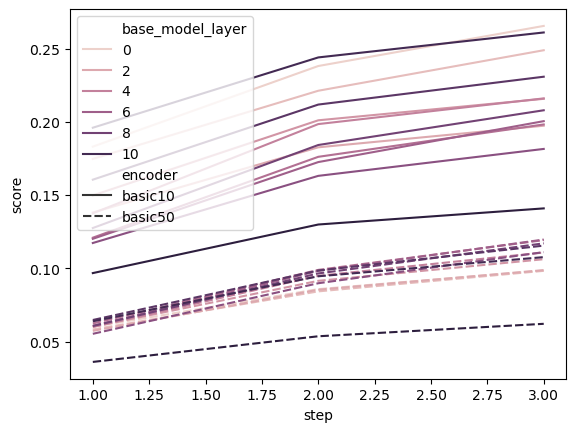

In [168]:
merged_df.pipe((sns.lineplot, "data"), x="step", y="score", hue="base_model_layer", style="encoder")

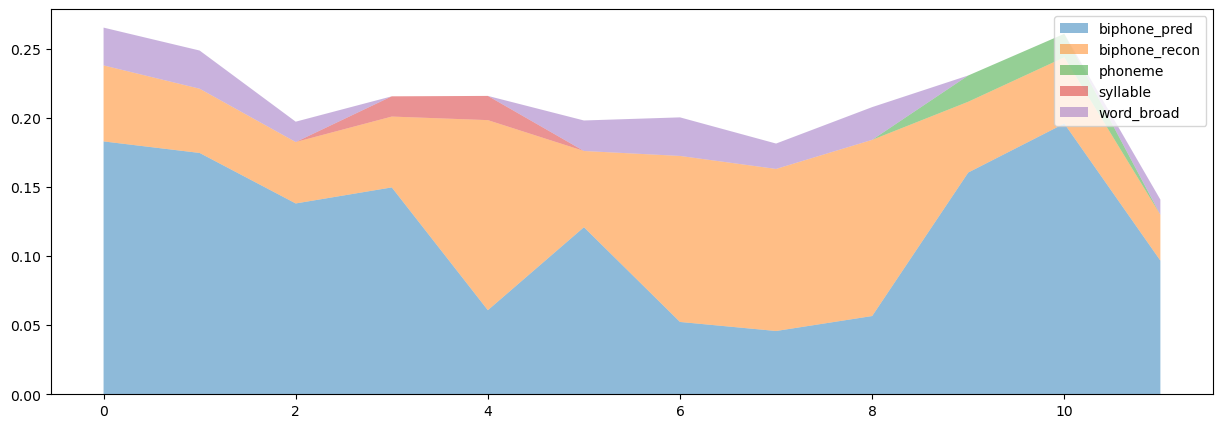

In [180]:
stack_plot_df = merged_df[merged_df.encoder == "basic10"].sort_values("base_model_layer").pivot_table(index="base_model_layer", columns="selected_embedding", values="improvement").fillna(0)
f, ax = plt.subplots(figsize=(15, 5))
ax.stackplot(stack_plot_df.index, stack_plot_df.T, labels=stack_plot_df.columns, alpha=0.5)
ax.legend()

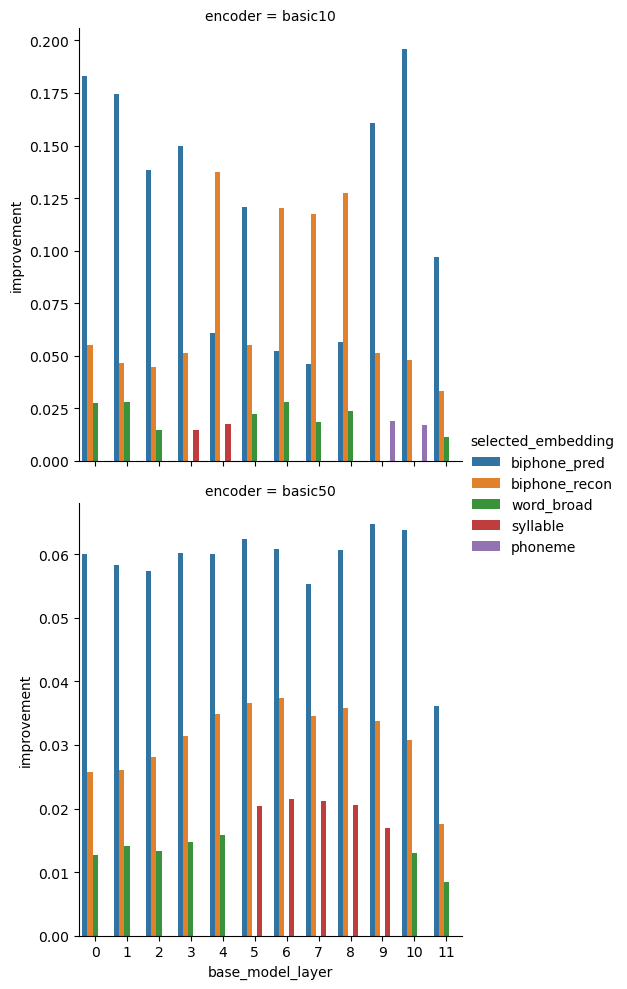

In [170]:
sns.catplot(data=merged_df, row="encoder",
            x="base_model_layer", y="improvement", hue="selected_embedding",
            kind="bar", sharey=False)

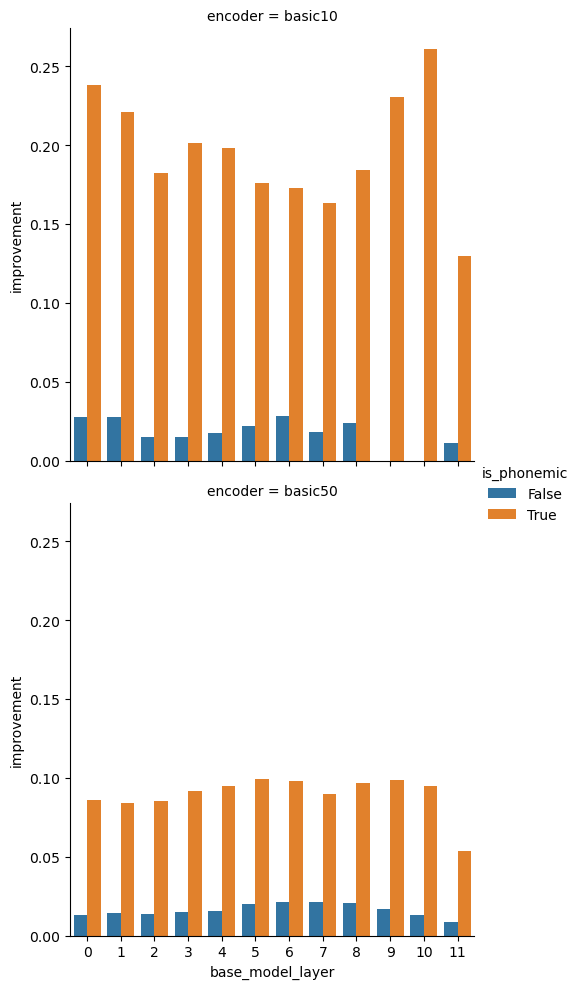

In [172]:
# Summarize improvement due to ~phonemic vs. >phonemic features
merged_df["is_phonemic"] = merged_df.selected_embedding.str.contains("phone")
sns.catplot(data=merged_df.groupby(["encoder", "base_model_layer", "is_phonemic"]).improvement.sum().reset_index(),
            row="encoder", x="base_model_layer", y="improvement", hue="is_phonemic", kind="bar")

## Sankey

In [173]:
selection_df

,encoder,base_model,step,selected_embedding
24,basic50,w2v2_7,1,biphone_pred
25,basic10,w2v2_7,1,biphone_recon
26,basic10,w2v2_0,1,biphone_pred
27,basic50,w2v2_0,1,biphone_pred
28,basic50,w2v2_10,1,biphone_pred
...,...,...,...,...
91,basic10,w2v2_2,3,word_broad
92,basic10,w2v2_11,3,word_broad
93,basic50,w2v2_11,3,word_broad
94,basic10,w2v2_5,3,word_broad


In [174]:
from ipysankeywidget import SankeyWidget

links = []
for group, rows in selection_df.groupby(["base_model", "encoder"]):
    for i, (e1, e2) in enumerate(zip(rows.selected_embedding, rows.selected_embedding[1:])):
        links.append({"source": e1, "target": e2, "value": 1 * (i + 1), "type": str(group)})

SankeyWidget(links=links)

SankeyWidget(links=[{'source': 'biphone_pred', 'target': 'biphone_recon', 'value': 1, 'type': "('w2v2_0', 'bas…